In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing  # Dataset exemple
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random
from tqdm import tqdm
import pandas as pd
from prophet import Prophet
from tqdm import tqdm
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random
from tqdm import tqdm


In [14]:
df = pd.read_csv("data.csv")

In [15]:
df.head()

,Domaine,Zone,Élément,Produit,Année,Valeur
0,Cultures et produits animaux,Maroc,Production,Ail frais,1961,2000.0
1,Cultures et produits animaux,Maroc,Production,Ail frais,1962,2000.0
2,Cultures et produits animaux,Maroc,Production,Ail frais,1963,3000.0
3,Cultures et produits animaux,Maroc,Production,Ail frais,1964,2000.0
4,Cultures et produits animaux,Maroc,Production,Ail frais,1965,1000.0


In [16]:
df.describe()

,Année,Valeur
count,1070.000000,1042.000000
mean,1991.971028,55071.899827
std,18.176510,110423.877949
min,1961.000000,0.000000
25%,1976.000000,2500.000000
50%,1992.000000,17375.000000
75%,2008.000000,50730.125000
max,2023.000000,922820.040000


In [17]:
df = df[['Année', 'Produit', 'Valeur']]

In [18]:
df.dropna(inplace=True)

In [19]:
df['Année'] = df['Année'].astype(int)
df['Année'] = pd.to_datetime(df['Année'], format='%Y')

In [20]:
Q1 = df["Valeur"].quantile(0.25)
Q3 = df["Valeur"].quantile(0.75)

IQR = Q3 - Q1

df = df[(df["Valeur"] >= (Q1 -1.5 * IQR)) & (df["Valeur"] <= (Q1 + 1.5 * IQR))]

In [21]:
df = df.rename(columns={'Année': 'ds','Produit' : 'product', 'Valeur': 'y'}).dropna()

In [22]:
df.head(4)

,ds,product,y
0,1961-01-01,Ail frais,2000.0
1,1962-01-01,Ail frais,2000.0
2,1963-01-01,Ail frais,3000.0
3,1964-01-01,Ail frais,2000.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 866 entries, 0 to 1069
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ds       866 non-null    datetime64[ns]
 1   product  866 non-null    object        
 2   y        866 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 27.1+ KB


In [20]:
df.to_csv("dataclean.csv", index=False)

In [28]:
def is_better(new_r2, new_mae, new_rmse, best_r2, best_mae, best_rmse):
    return (new_r2 > best_r2) or (new_rmse < best_rmse) or (new_mae < best_mae)


produits = df["product"].unique()
nb_essais = 100  

lignes_best = []   
futures = []       

for produit in produits:
    data = df.loc[df["product"] == produit, ["ds", "y"]].copy()
    if len(data) < 5:
        continue

    meilleur_r2   = -np.inf
    meilleur_mae  = np.inf
    meilleur_rmse = np.inf
    meilleur_params = None

    for _ in range(nb_essais):
            params = {
                "changepoint_prior_scale": random.uniform(0.001, 0.5),
                "seasonality_prior_scale": random.uniform(0.01, 20),
                "holidays_prior_scale": random.uniform(0.01, 20),
                "seasonality_mode": random.choice(["additive", "multiplicative"]),
                "changepoint_range": random.uniform(0.8, 0.95),
            }

            model = Prophet(**params)
            model.fit(data)

            forecast_hist = model.predict(data[["ds"]])
            y_true = data["y"].values
            y_pred = forecast_hist["yhat"].values

            r2   = r2_score(y_true, y_pred)
            mae  = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))

            if is_better(r2, mae, rmse, meilleur_r2, meilleur_mae, meilleur_rmse):
                meilleur_r2, meilleur_mae, meilleur_rmse = r2, mae, rmse
                meilleur_params = params


    if meilleur_params is not None:
        
            best_model = Prophet(**meilleur_params)
            best_model.fit(data)

            future_dates = pd.date_range(start="2023-01-01", end="2040-01-01", freq="YS")
            forecast_future = best_model.predict(pd.DataFrame({"ds": future_dates}))

            prev = forecast_future[["ds", "yhat"]].copy()
            prev["product"] = produit
            futures.append(prev)

            lignes_best.append({
                "product": produit,
                "r2_score": meilleur_r2,
                "mae": meilleur_mae,
                "rmse": meilleur_rmse,
                **meilleur_params
            })


df_final = pd.DataFrame(lignes_best)
if futures:
    df_futures = pd.concat(futures, ignore_index=True)
    df_futures.rename(columns={"ds": "date", "yhat": "prediction_en_tonnes"}, inplace=True)
    df_futures = df_futures[["date", "product", "prediction_en_tonnes"]]
else:
    df_futures = pd.DataFrame(columns=["date", "product", "prediction_en_tonnes"])

print("df_final : meilleurs hyperparamètres")
print("df_futures : prévisions 2040 par produit")


20:21:14 - cmdstanpy - INFO - Chain [1] start processing
20:21:16 - cmdstanpy - INFO - Chain [1] done processing
20:21:16 - cmdstanpy - INFO - Chain [1] start processing
20:21:16 - cmdstanpy - INFO - Chain [1] done processing
20:21:17 - cmdstanpy - INFO - Chain [1] start processing
20:21:18 - cmdstanpy - INFO - Chain [1] done processing
20:21:18 - cmdstanpy - INFO - Chain [1] start processing
20:21:19 - cmdstanpy - INFO - Chain [1] done processing
20:21:19 - cmdstanpy - INFO - Chain [1] start processing
20:21:20 - cmdstanpy - INFO - Chain [1] done processing
20:21:20 - cmdstanpy - INFO - Chain [1] start processing
20:21:20 - cmdstanpy - INFO - Chain [1] done processing
20:21:21 - cmdstanpy - INFO - Chain [1] start processing
20:21:21 - cmdstanpy - INFO - Chain [1] done processing
20:21:21 - cmdstanpy - INFO - Chain [1] start processing
20:21:23 - cmdstanpy - INFO - Chain [1] done processing
20:21:23 - cmdstanpy - INFO - Chain [1] start processing
20:21:24 - cmdstanpy - INFO - Chain [1]

✅ Terminé :
 - df_final : meilleurs hyperparamètres + métriques par produit
 - df_futures : prévisions 2023→2040 par produit


In [29]:
df_final

,product,r2_score,mae,rmse,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,changepoint_range
0,Ail frais,0.887259,1185.866686,2175.779308,0.334776,13.697593,13.426043,multiplicative,0.828042
1,Artichauts,0.943448,2250.525125,3076.766618,0.390952,16.129063,15.650051,multiplicative,0.881326
2,Aubergines,0.960428,2198.606063,4016.086773,0.495820,10.087295,9.831666,multiplicative,0.918755
3,Avocats,0.988681,915.099234,1773.000770,0.467033,4.924286,19.721060,multiplicative,0.913613
4,Carottes et navets,1.000000,0.578324,0.625832,0.245746,18.101986,14.567736,multiplicative,0.940832
5,Cerises,0.917847,823.709771,1562.467735,0.442154,6.339040,10.824805,multiplicative,0.900478
6,Champignons et truffes,0.998707,14.192286,25.250909,0.461550,5.760542,7.091561,multiplicative,0.808027
7,Citrons et limes,0.955689,1881.392239,2432.287127,0.375525,7.999900,12.077843,multiplicative,0.894586
8,Coings,0.972892,1795.129175,2982.211118,0.386817,16.532275,19.396317,multiplicative,0.933726
9,"Concombres, cornichons",0.969865,2232.641683,3769.419494,0.227604,16.474997,15.023392,multiplicative,0.886743


In [28]:
df_futures

,date,product,prediction_en_tonnes
0,2023-01-01,Ail frais,17841.346915
1,2024-01-01,Ail frais,18908.956959
2,2025-01-01,Ail frais,19574.760638
3,2026-01-01,Ail frais,20669.609376
4,2027-01-01,Ail frais,21761.142675
...,...,...,...
301,2036-01-01,Vin,49422.608747
302,2037-01-01,Vin,50899.089051
303,2038-01-01,Vin,51307.911790
304,2039-01-01,Vin,51673.991878


In [29]:
df_futures.to_csv("prevision_2040.csv", index=False)

# Entrainement :

In [11]:
produits = df["product"].unique()  # Liste des produits uniques
resultats = []  # Pour stocker les prévisions optimisées

# 2. Fonction pour générer des paramètres aléatoires Prophet
def generer_parametres():
    return {
        "changepoint_prior_scale": random.uniform(0.001, 0.5),
        "seasonality_prior_scale": random.uniform(0.01, 20),
        "holidays_prior_scale": random.uniform(0.01, 20),
        "seasonality_mode": random.choice(["additive", "multiplicative"]),
        "changepoint_range": random.uniform(0.8, 0.95)
    }

# 3. Fonction de score combiné (plus le score est haut, mieux c’est)
def global_score(r2, mae, mse, mae_penalty=1.0, mse_penalty=0.5):
    return r2 - (mae_penalty * mae) - (mse_penalty * mse)

# 4. Boucle sur tous les produits
for produit in produits:
    data = df[df["product"] == produit][["ds", "y"]].copy()

    if len(data) < 5:
        continue  # Trop peu de données

    meilleur_score = -np.inf
    meilleur_resultat = None

    # Random Search : tester 50 combinaisons
    for _ in range(50):
        try:
            params = generer_parametres()
            model = Prophet(**params)
            model.fit(data)

            future = model.make_future_dataframe(periods=15, freq="YS")
            forecast = model.predict(future)

            # Évaluer sur les données historiques
            y_true = data["y"].values
            y_pred = forecast.iloc[:len(data)]["yhat"].values

            # Métriques
            r2 = r2_score(y_true, y_pred)
            mae = mean_absolute_error(y_true, y_pred)
            mse = mean_squared_error(y_true, y_pred)
            score = global_score(r2, mae, mse)  # Utilisation du score combiné

            # Meilleur modèle ?
            if score > meilleur_score:
                meilleur_score = score
                meilleur_resultat = forecast.copy()
                meilleur_resultat["product"] = produit
                meilleur_resultat["r2_score"] = r2
                meilleur_resultat["mae"] = mae
                meilleur_resultat["mse"] = mse

                for key, val in params.items():
                    meilleur_resultat[key] = val

                # Ajouter les vraies valeurs y
                meilleur_resultat["y"] = list(y_true) + [None] * (len(forecast) - len(data))

        except Exception:
            continue  # Sauter les erreurs

    if meilleur_resultat is not None:
        resultats.append(meilleur_resultat)

# 5. Sauvegarder les résultats
if resultats:
    df_final = pd.concat(resultats)
    colonnes = ["ds", "product", "r2_score", "mae", "mse",
                "changepoint_prior_scale", "seasonality_prior_scale",
                "holidays_prior_scale", "seasonality_mode", "changepoint_range"]
    df_final = df_final[colonnes]
    print("✅ Résultats sauvegardés dans df_final")

11:56:46 - cmdstanpy - INFO - Chain [1] start processing
11:56:47 - cmdstanpy - INFO - Chain [1] done processing
11:56:47 - cmdstanpy - INFO - Chain [1] start processing
11:56:47 - cmdstanpy - INFO - Chain [1] done processing
11:56:48 - cmdstanpy - INFO - Chain [1] start processing
11:56:48 - cmdstanpy - INFO - Chain [1] done processing
11:56:49 - cmdstanpy - INFO - Chain [1] start processing
11:56:50 - cmdstanpy - INFO - Chain [1] done processing
11:56:50 - cmdstanpy - INFO - Chain [1] start processing
11:56:50 - cmdstanpy - INFO - Chain [1] done processing
11:56:51 - cmdstanpy - INFO - Chain [1] start processing
11:56:51 - cmdstanpy - INFO - Chain [1] done processing
11:56:51 - cmdstanpy - INFO - Chain [1] start processing
11:56:52 - cmdstanpy - INFO - Chain [1] done processing
11:56:53 - cmdstanpy - INFO - Chain [1] start processing
11:56:54 - cmdstanpy - INFO - Chain [1] done processing
11:56:54 - cmdstanpy - INFO - Chain [1] start processing
11:56:55 - cmdstanpy - INFO - Chain [1]

✅ Résultats sauvegardés dans df_final


In [12]:
df_final

,ds,product,r2_score,mae,mse,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,changepoint_range
0,1961-01-01,Ail frais,0.902368,1212.377255,4.099586e+06,0.431431,19.778755,3.229058,multiplicative,0.885970
1,1962-01-01,Ail frais,0.902368,1212.377255,4.099586e+06,0.431431,19.778755,3.229058,multiplicative,0.885970
2,1963-01-01,Ail frais,0.902368,1212.377255,4.099586e+06,0.431431,19.778755,3.229058,multiplicative,0.885970
3,1964-01-01,Ail frais,0.902368,1212.377255,4.099586e+06,0.431431,19.778755,3.229058,multiplicative,0.885970
4,1965-01-01,Ail frais,0.902368,1212.377255,4.099586e+06,0.431431,19.778755,3.229058,multiplicative,0.885970
...,...,...,...,...,...,...,...,...,...,...
56,2033-01-01,Vin,0.867844,3463.589393,2.417431e+07,0.286792,9.150984,0.044441,multiplicative,0.836004
57,2034-01-01,Vin,0.867844,3463.589393,2.417431e+07,0.286792,9.150984,0.044441,multiplicative,0.836004
58,2035-01-01,Vin,0.867844,3463.589393,2.417431e+07,0.286792,9.150984,0.044441,multiplicative,0.836004
59,2036-01-01,Vin,0.867844,3463.589393,2.417431e+07,0.286792,9.150984,0.044441,multiplicative,0.836004


In [13]:
import pandas as pd
from prophet import Prophet
from tqdm import tqdm


produits = df["product"].unique()

# 3. Initialiser la liste pour stocker toutes les prévisions
futures = []

# 4. Boucle sur chaque produit
for produit in produits:
    try:
        # a. Récupérer les meilleurs paramètres pour ce produit
        ligne = df_final[df_final["product"] == produit].iloc[0]

        params = {
            "changepoint_prior_scale": ligne["changepoint_prior_scale"],
            "seasonality_prior_scale": ligne["seasonality_prior_scale"],
            "holidays_prior_scale": ligne["holidays_prior_scale"],
            "seasonality_mode": ligne["seasonality_mode"],
            "changepoint_range": ligne["changepoint_range"]
        }

        # b. Récupérer les données historiques pour ce produit
        data = df[df["product"] == produit][["ds", "y"]].copy()

        # c. Entraîner Prophet avec les paramètres optimisés
        model = Prophet(**params)
        model.fit(data)

        # d. Créer manuellement les dates futures de 2023 à 2040
        future_dates = pd.date_range(start="2023-01-01", end="2040-01-01", freq="YS")
        future = pd.DataFrame({"ds": future_dates})

        # e. Générer les prévisions
        forecast = model.predict(future)

        # f. Ajouter le produit et ne garder que les colonnes utiles
        previsions = forecast[["ds", "yhat"]].copy()
        previsions["product"] = produit

        futures.append(previsions)

    except Exception as e:
        print(f"❌ Erreur avec le produit '{produit}' : {e}")
        continue

# 5. Fusionner toutes les prévisions
df_futures = pd.concat(futures)
df_futures.rename(columns={"ds": "date", "yhat": "prediction_en_tonnes"}, inplace=True)
df_futures = df_futures[["date", "product", "prediction_en_tonnes"]]

# 6. Sauvegarder dans un fichier CSV
#df_futures.to_csv("previsions_futures_2040.csv", index=False)
print("✅ Fichier sauvegardé : previsions_futures_2040.csv")


12:13:55 - cmdstanpy - INFO - Chain [1] start processing
12:13:56 - cmdstanpy - INFO - Chain [1] done processing
12:13:56 - cmdstanpy - INFO - Chain [1] start processing
12:13:58 - cmdstanpy - INFO - Chain [1] done processing
12:13:58 - cmdstanpy - INFO - Chain [1] start processing
12:13:59 - cmdstanpy - INFO - Chain [1] done processing
12:13:59 - cmdstanpy - INFO - Chain [1] start processing
12:14:00 - cmdstanpy - INFO - Chain [1] done processing
12:14:00 - cmdstanpy - INFO - Chain [1] start processing
12:14:16 - cmdstanpy - INFO - Chain [1] done processing
12:14:16 - cmdstanpy - INFO - Chain [1] start processing
12:14:17 - cmdstanpy - INFO - Chain [1] done processing
12:14:17 - cmdstanpy - INFO - Chain [1] start processing
12:14:17 - cmdstanpy - INFO - Chain [1] done processing
12:14:17 - cmdstanpy - INFO - Chain [1] start processing
12:14:18 - cmdstanpy - INFO - Chain [1] done processing
12:14:18 - cmdstanpy - INFO - Chain [1] start processing
12:14:19 - cmdstanpy - INFO - Chain [1]

✅ Fichier sauvegardé : previsions_futures_2040.csv


In [14]:
df.head()

,ds,product,y
0,1961-01-01,Ail frais,2000.0
1,1962-01-01,Ail frais,2000.0
2,1963-01-01,Ail frais,3000.0
3,1964-01-01,Ail frais,2000.0
4,1965-01-01,Ail frais,1000.0


In [24]:
df_futures.head()

,date,product,prediction_en_tonnes
0,2023-01-01,Ail frais,18591.451379
1,2024-01-01,Ail frais,19688.447623
2,2025-01-01,Ail frais,21289.995456
3,2026-01-01,Ail frais,22416.115718
4,2027-01-01,Ail frais,23512.467733


In [25]:
df_futures.to_csv("prediction_2040.csv", index=False)

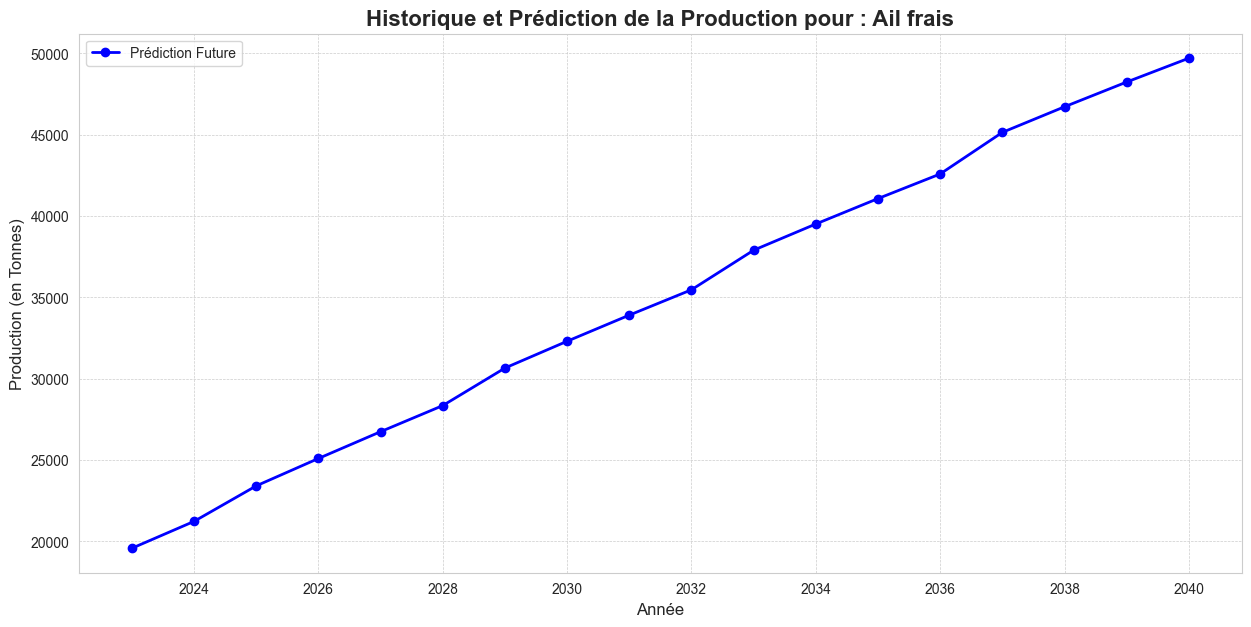

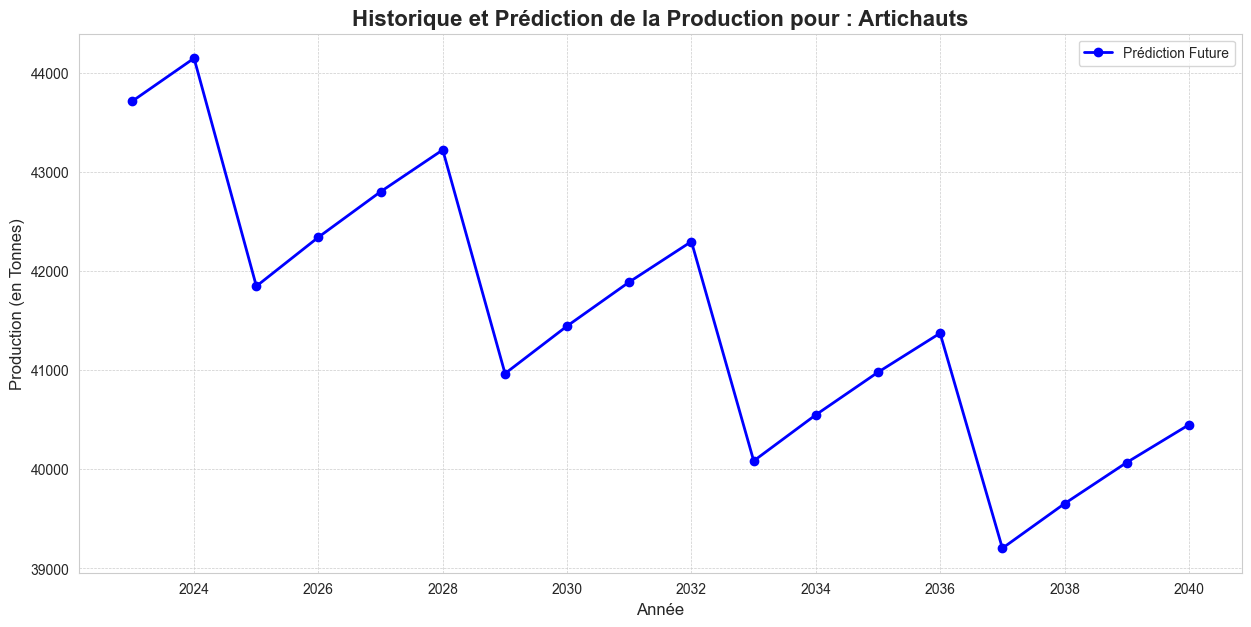

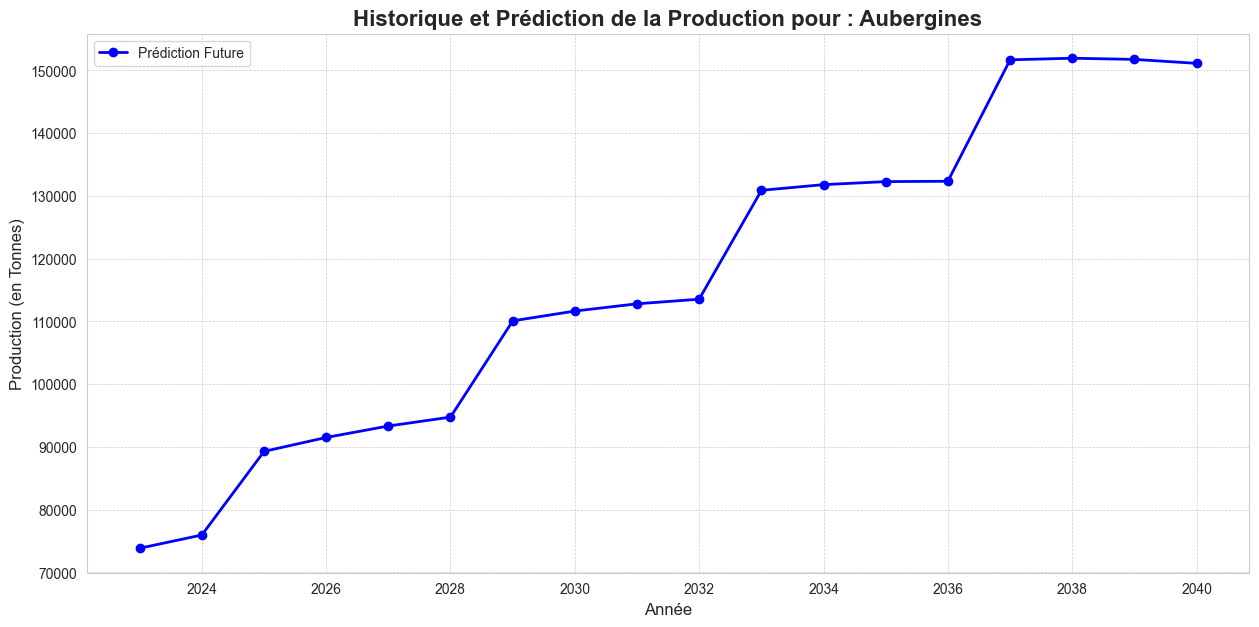

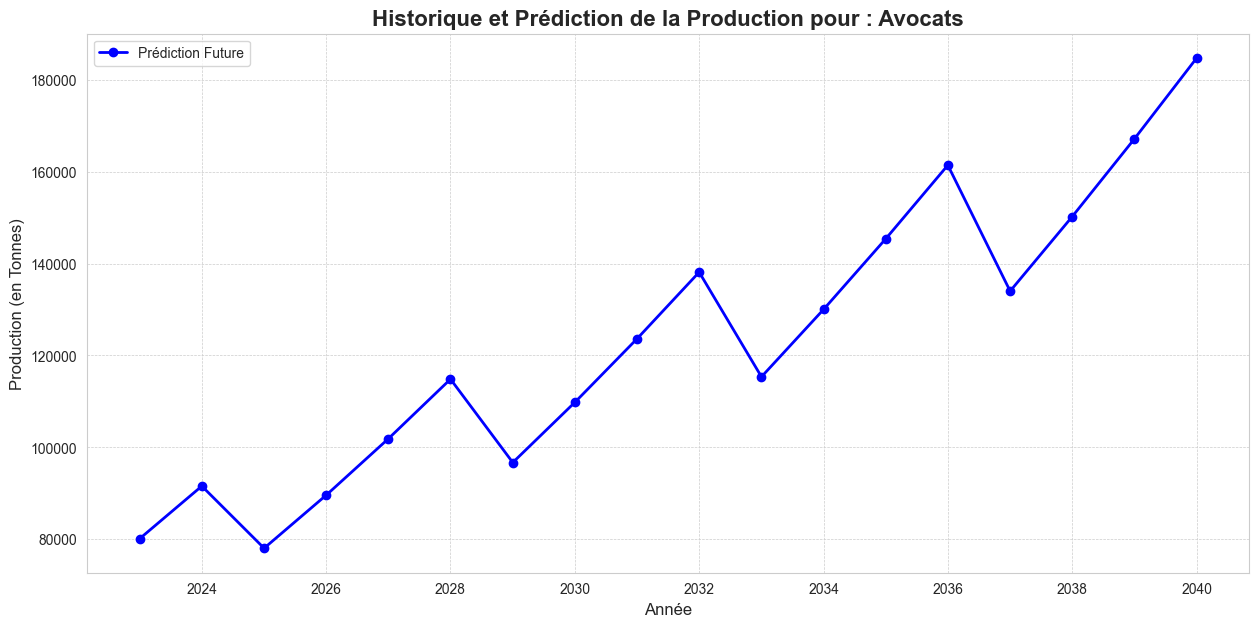

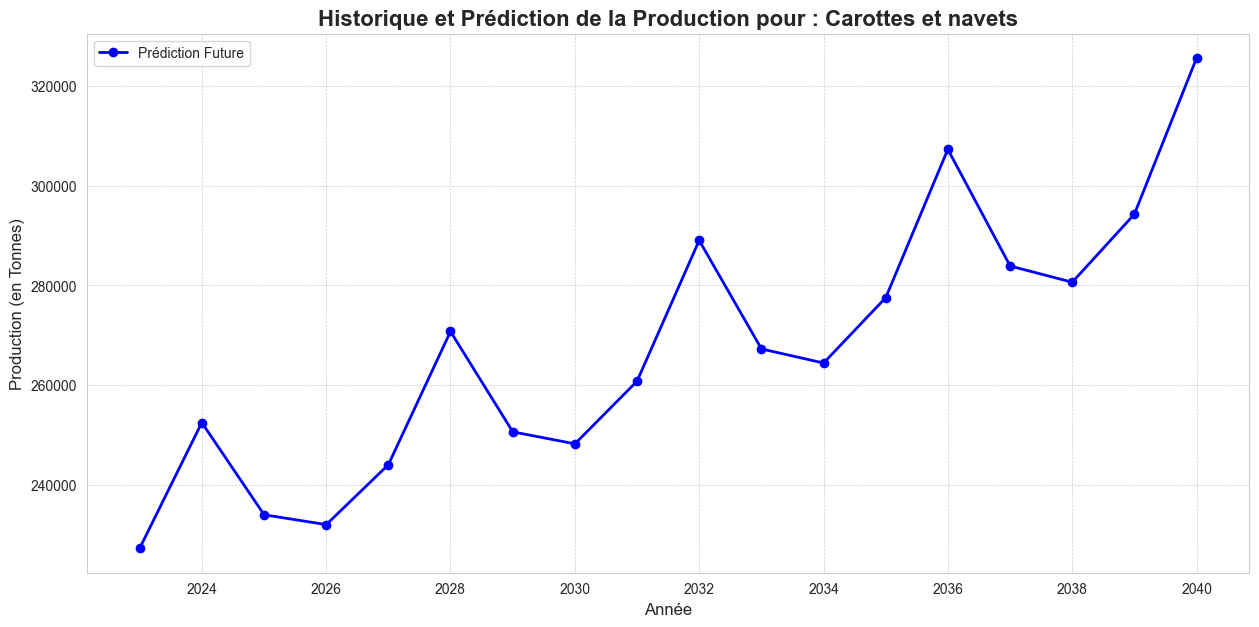

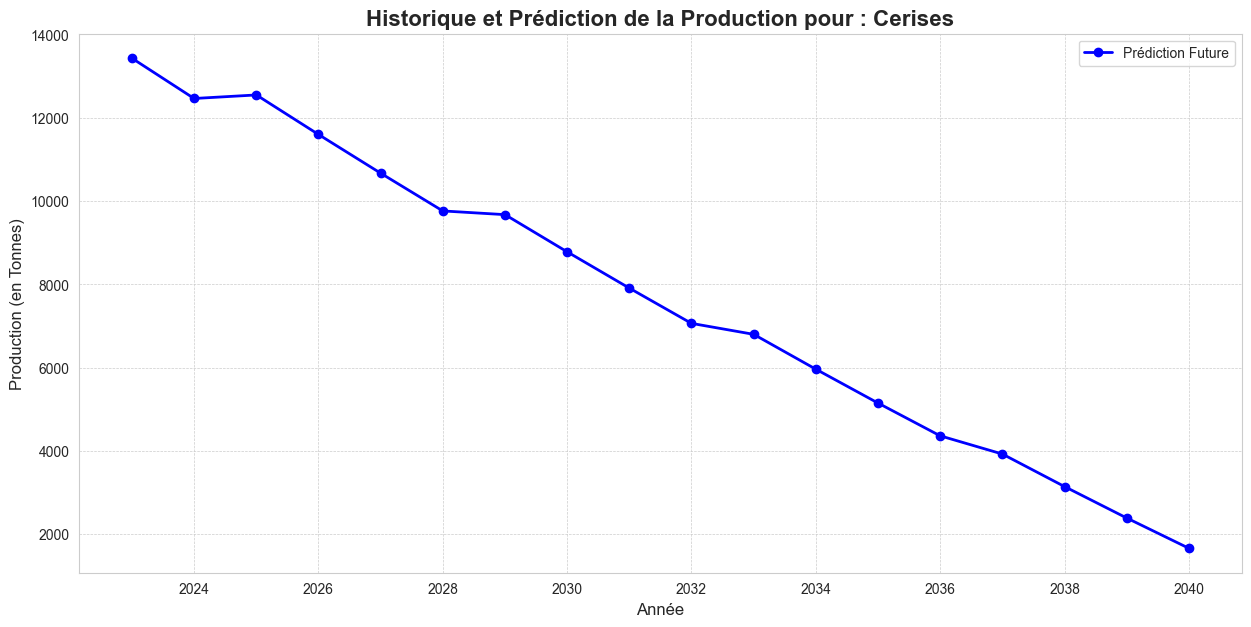

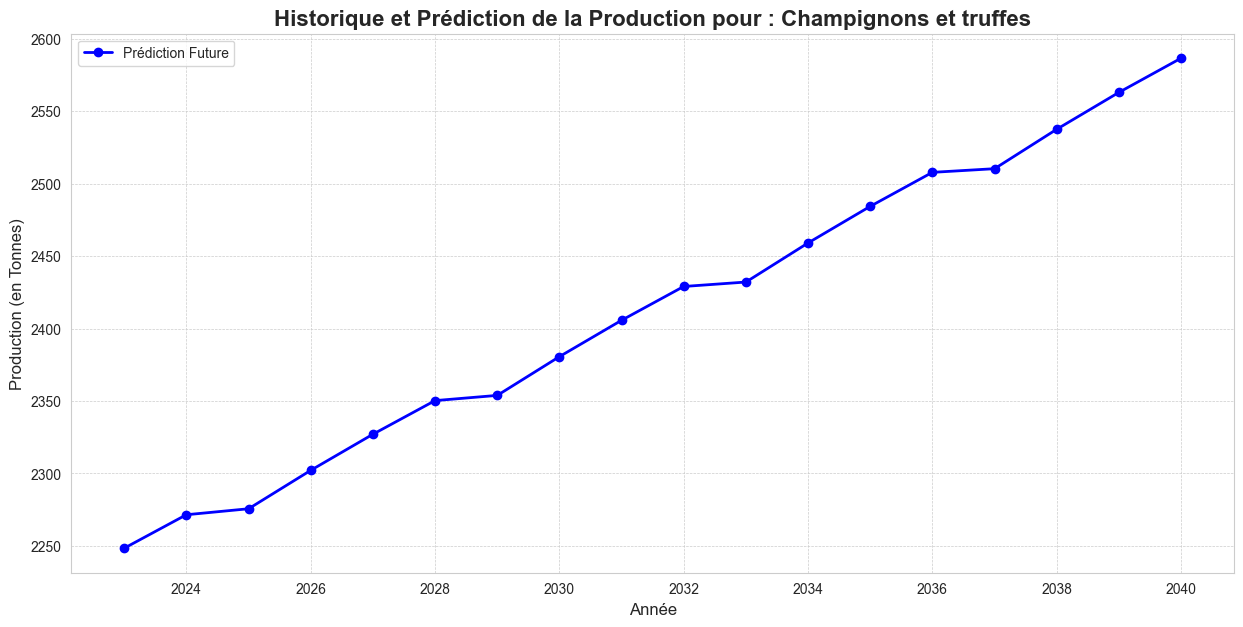

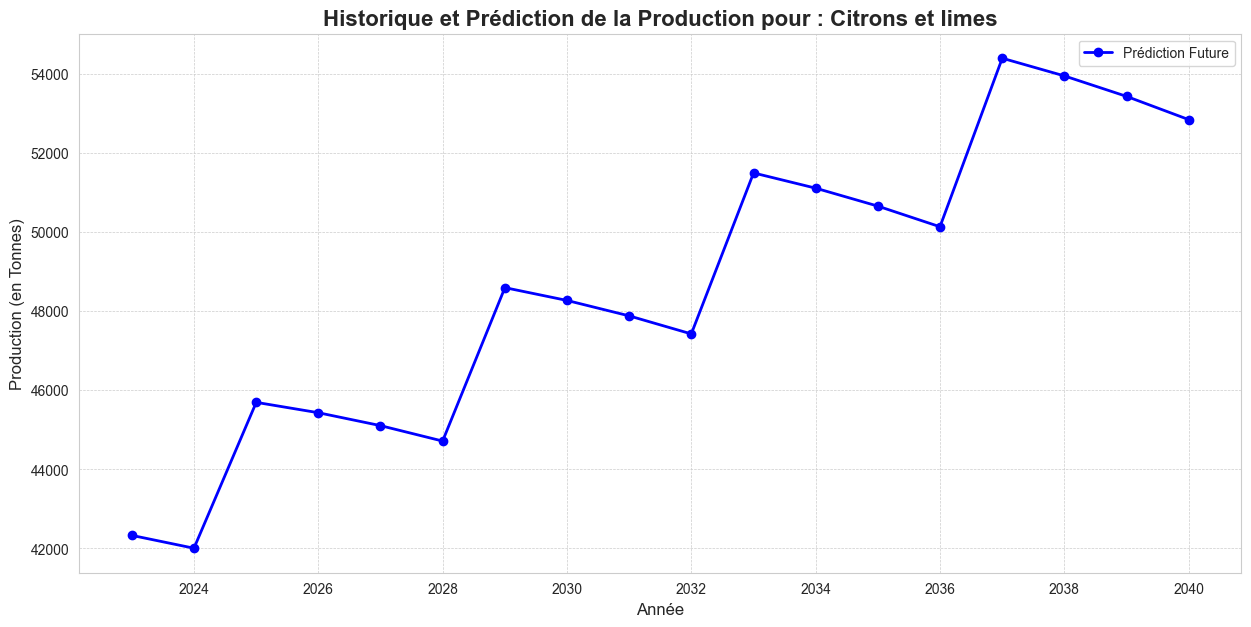

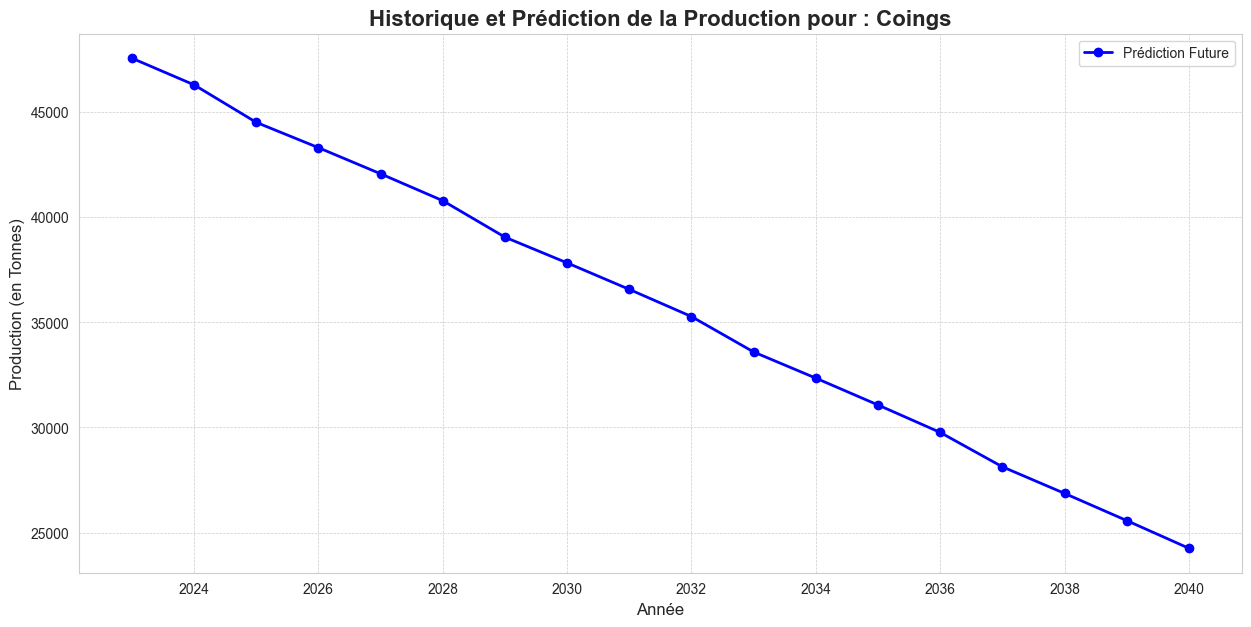

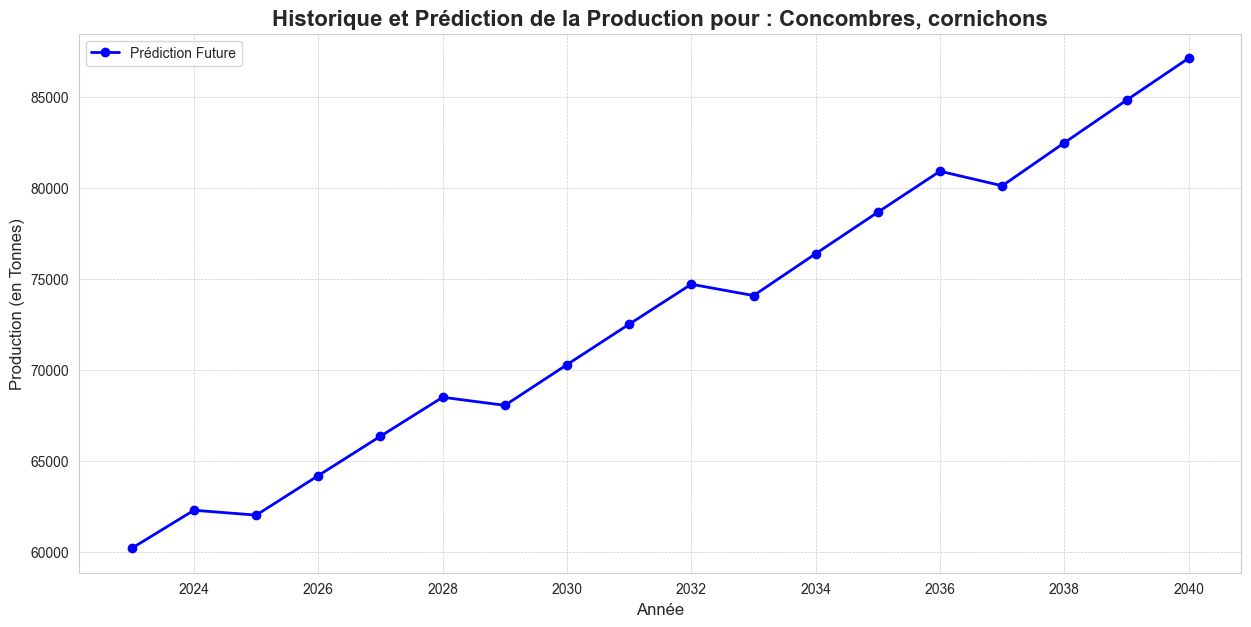

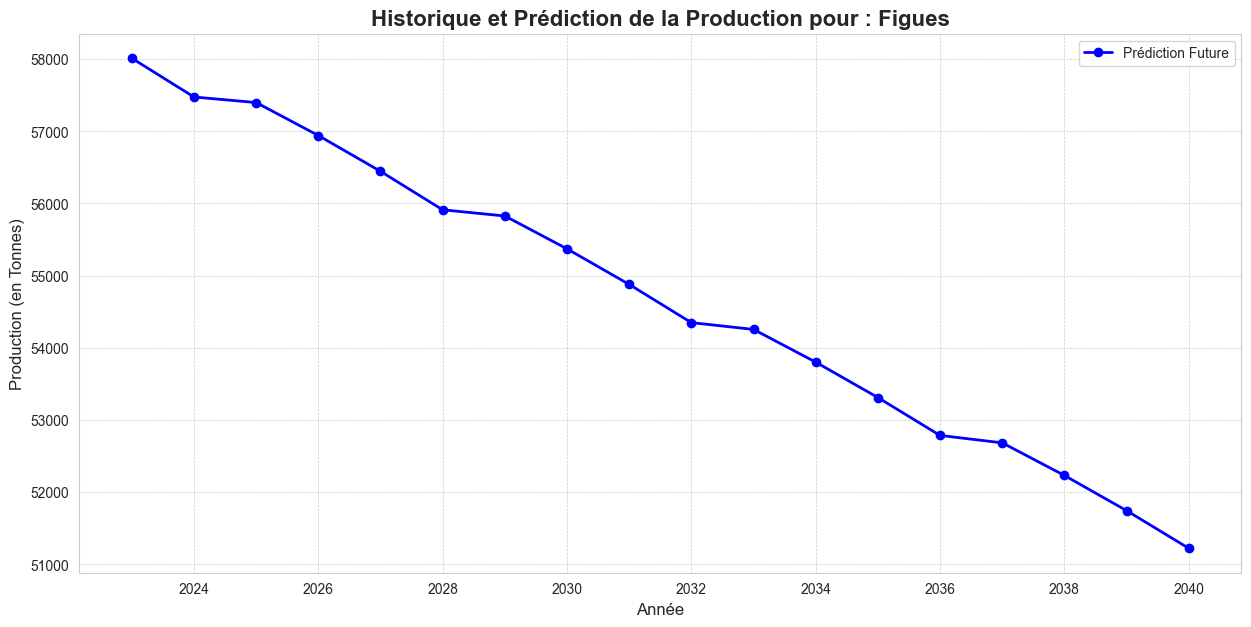

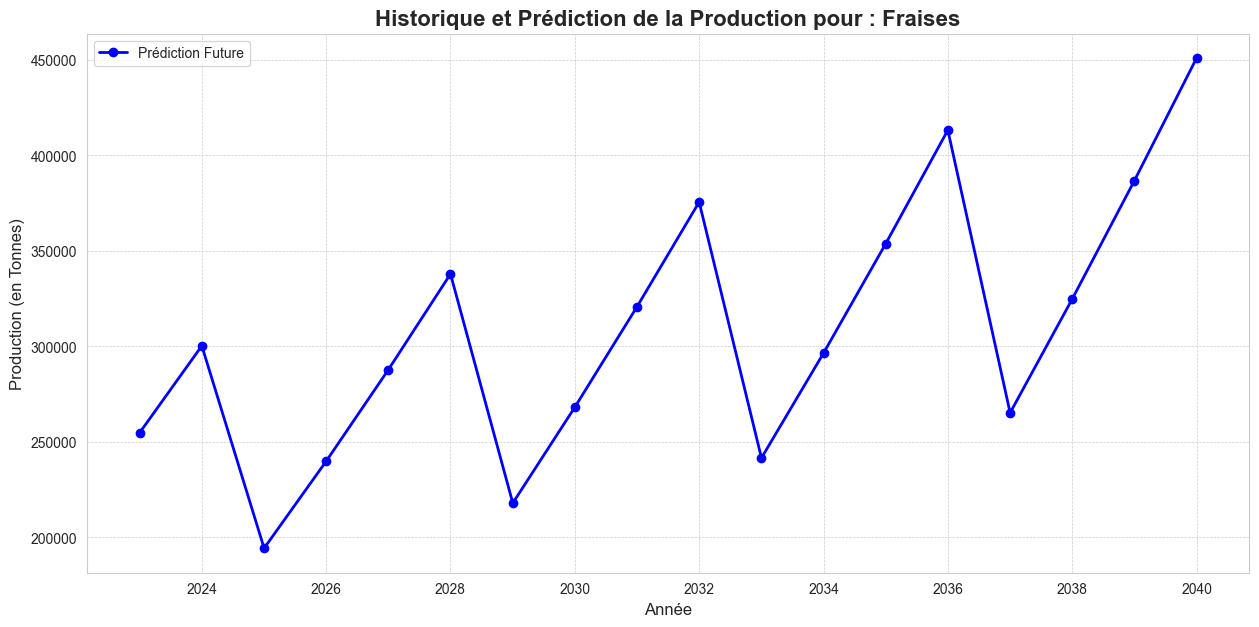

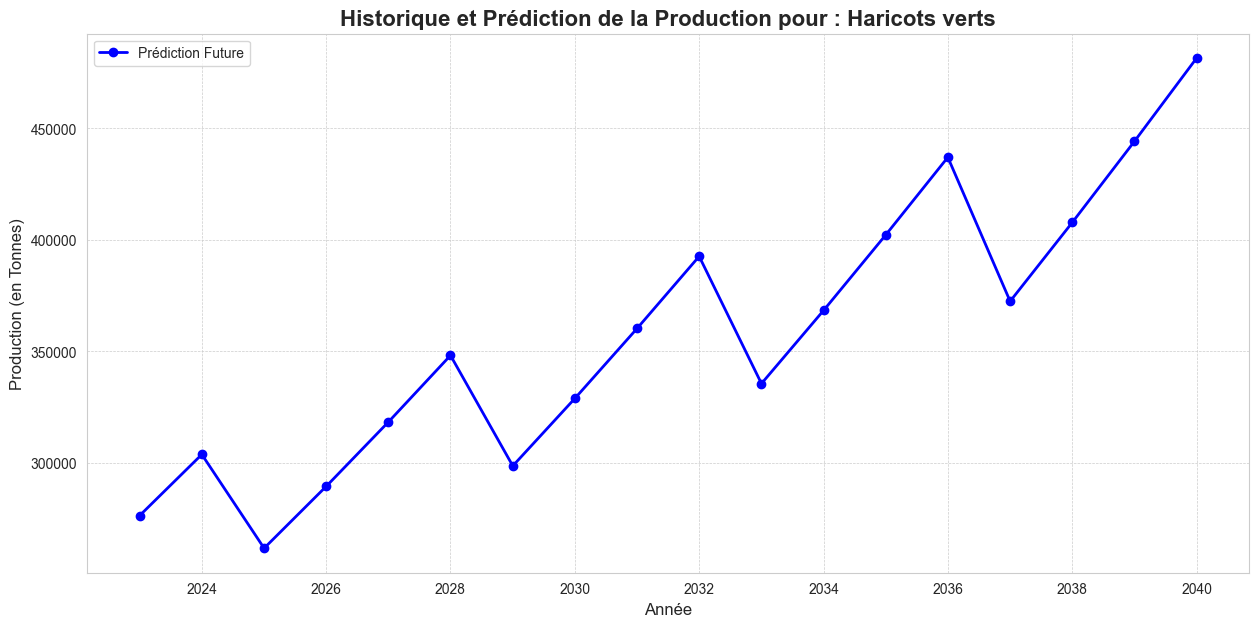

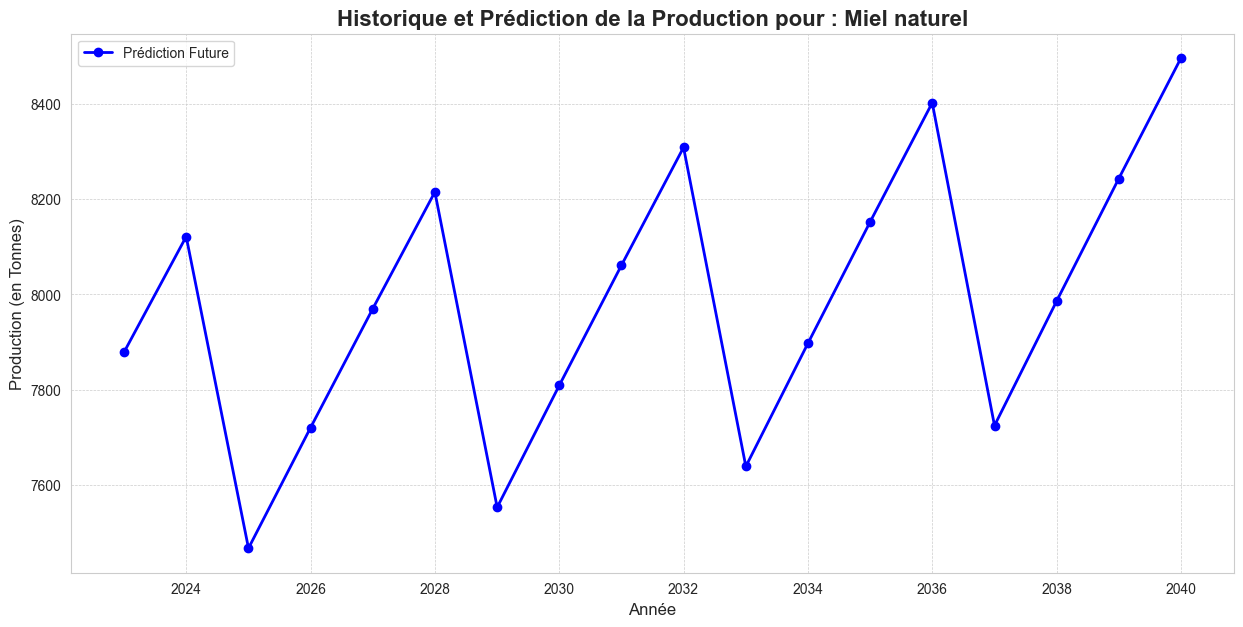

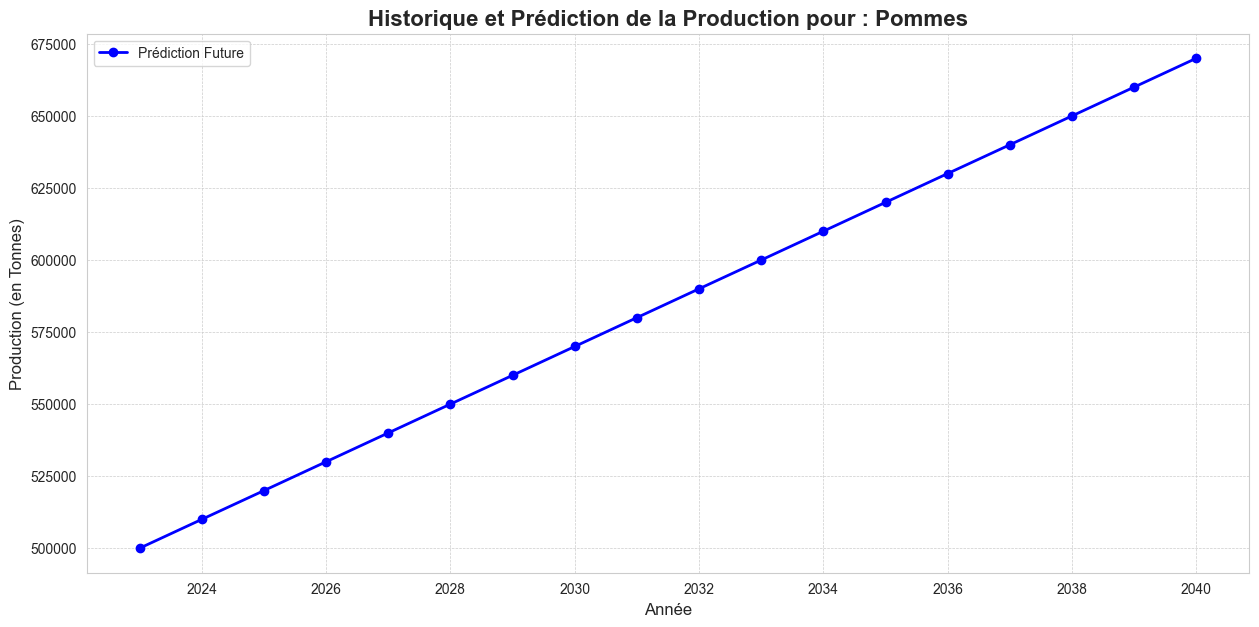

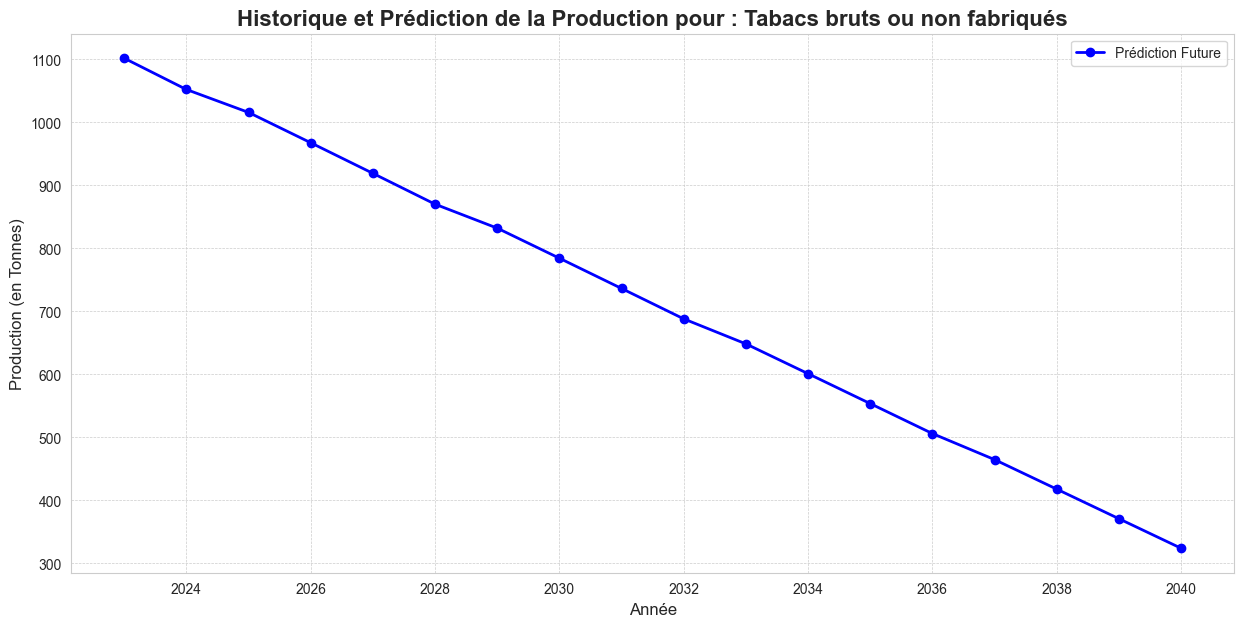

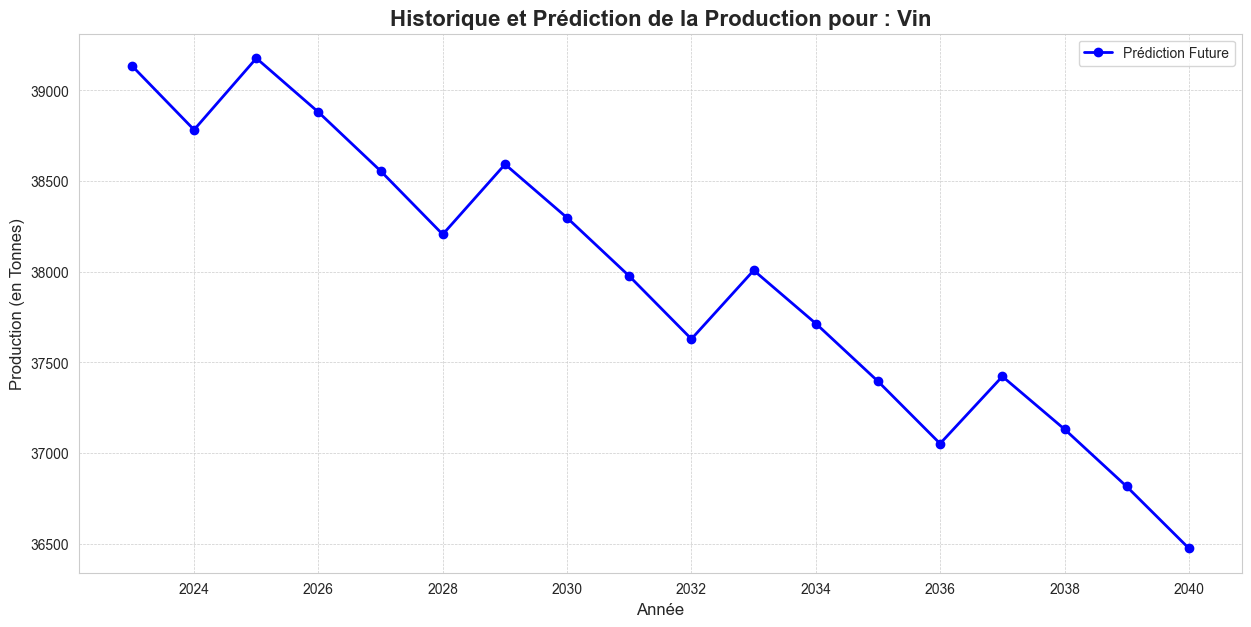


✅ Graphiques générés avec continuité entre historique et prédiction.


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_predictions():
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (15, 7)
    plt.rcParams['figure.dpi'] = 100


    # --- Chargement des prédictions ---
    df_predictions = df_futures.copy()  # variable venant de ton notebook
    # Uniformiser le format de date
    df_predictions['date'] = pd.to_datetime(df_predictions['date'], errors='coerce')

    available_products = df_predictions['product'].unique()

    for product in available_products:
        predictions_product = df_predictions[df_predictions['product'] == product]

        # Fusionner historique et prédictions pour un tracé continu
        combined = pd.DataFrame({
            'date': pd.concat([predictions_product['date']]),
            'production': pd.concat([predictions_product['prediction_en_tonnes']])
        })

        plt.figure()
        # Historique
        # Prédictions (prolongeant la courbe)
        plt.plot(predictions_product['date'], predictions_product['prediction_en_tonnes'],
                 label='Prédiction Future', color='blue', marker='o', linewidth=2)

        # Mettre en forme
        plt.title(f"Historique et Prédiction de la Production pour : {product}", fontsize=16, fontweight='bold')
        plt.xlabel("Année", fontsize=12)
        plt.ylabel("Production (en Tonnes)", fontsize=12)
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

        plt.show()

    print("\n✅ Graphiques générés avec continuité entre historique et prédiction.")

if __name__ == '__main__':
    visualize_predictions()